## Imports

In [23]:
### Imports
# Modules
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
import os
import errno

# utils
from sklearn.utils import shuffle
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from matplotlib import gridspec

# Keras
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, Dropout, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.utils import plot_model

# Utils
from utils import delete_file, crop, resize, conv_to_graysale
from utils import random_brightness_correction, random_flip, random_shear, random_rotate
from utils import transformed_data_generator, original_data_generator, lenet_generator

# Plot in the notebook
%matplotlib inline

ImportError: cannot import name 'lenet_generator'

## Constants and generic utils

In [2]:
### Constants
# Data
DATA_DIR = 'data/'
CSV_FILE = 'driving_log.csv'

# Resize constants
TOP_CUT = 30
BOTTOM_CUT = 30
NEW_WIDTH = 64
NEW_HEIGHT = 64
MAX_ROTATION_ANGLE = 15
MAX_SHEAR_SHIFT = 40

# Data generation constants
BATCH_SIZE = 32
STEERING_CORRECTION = 0.23

# Camera parameters
cameras = ['center', 'left', 'right']
cameras_index = {'center':0, 'left':1, 'right':2} # 0:center, 1:left, 2:right

## Data exploration

In [3]:
### Load data
# Load csv log file
csv_file = []
with open(DATA_DIR+CSV_FILE) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        csv_file.append(line)

In [4]:
# Split csv in train and validation sets
csv_train, csv_valid = train_test_split(csv_file, test_size = 0.2)

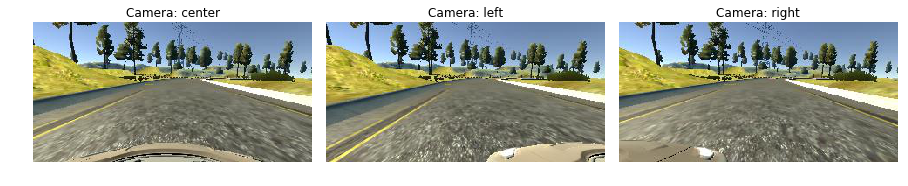

In [5]:
### Sample image
# Get sample image for testing
sample_idx = np.random.choice(len(csv_file))
sample_line = csv_file[sample_idx]
path = DATA_DIR + sample_line[0].strip()
sample_image = cv2.imread(path)
sample_angle = float(csv_file[sample_idx][3])

fig = plt.figure(figsize = (12, 3))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for camera in cameras:
    path = DATA_DIR + sample_line[cameras_index[camera]].strip()
    image = cv2.imread(path)
    imgplt = fig.add_subplot(1, 3, cameras_index[camera]+1)
    imgplt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('Camera: '+camera, fontsize = 12)

fig.savefig('report-images/cameras_image')

In [6]:
### Driving log exploration
import pandas as pd
pd_data = pd.read_csv(DATA_DIR+CSV_FILE)
pd_data[:5]

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


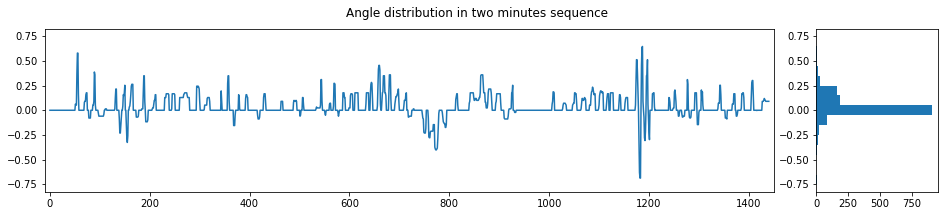

In [7]:
### Angle distribution
counter = 0
angles = []
times = []
for line in csv_file:
    angles.append(float(line[3]))
    times.append(counter)
    counter += 1
    if counter > 12*60*2: break
bins = [-0.75 + 0.1*counter for counter in range(16)]

fig = plt.figure(figsize=(16, 3)) 
fig.subplots_adjust(hspace = 0.1, wspace = 0.1)
fig.suptitle("Angle distribution in two minutes sequence")
gs = gridspec.GridSpec(1, 2, width_ratios=[18, 3]) 
ax0 = plt.subplot(gs[0])
ax0.plot(times, angles)
ax0.axis([-10, 12*60*2+10, -0.75, 0.75])
ax1 = plt.subplot(gs[1], sharey=ax0)
hst = ax1.hist(angles, bins = bins, orientation="horizontal")

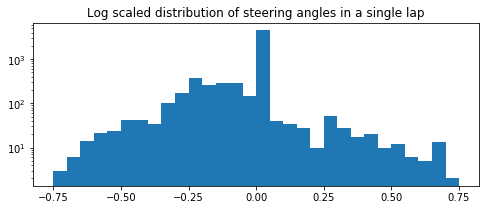

In [8]:
# Load csv log file
csv_skew_file = []
with open('new-data/'+CSV_FILE) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        csv_skew_file.append(line)

angles = []
for line in csv_skew_file:
    angles.append(float(line[3]))
max_angle = 0.75
step = 0.05
bins = [-max_angle + step*counter for counter in range(int(max_angle*2/step)+1)]
fig = plt.figure(figsize=(8, 3)) 
hst = plt.hist(angles, bins)
plt.yscale('log')#, nonposy='clip')
axis = plt.xticks([-0.75+0.25*counter for counter in range(7)])
title = plt.title('Log scaled distribution of steering angles in a single lap')

## Data processing

In [9]:
### Testing image transformation
def print_sample_transformation(tr_func, tr_name, image, *argv):
    
    fig = plt.figure(figsize = (15, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    # Print non-transformed image
    counter = 1
    imgplt = fig.add_subplot(1, 5, counter)
    imgplt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('Original', fontsize = 12)
    counter += 1
    # Print transformed images
    print_title = True
    for idx in range(4):
        imgplt = fig.add_subplot(1, 5, counter)
        if tr_func == conv_to_graysale:
            tr_image = tr_func(image)
            imgplt.imshow(tr_image.squeeze(), cmap='gray_r')
        else:
            tr_image, tr_angle = tr_func(image, *argv)
            imgplt.imshow(cv2.cvtColor(tr_image, cv2.COLOR_BGR2RGB))
        imgplt.axis('off')
        if print_title:
            imgplt.set_title(tr_name, loc = 'left', fontsize = 12)
            print_title = False
        counter += 1
    return fig

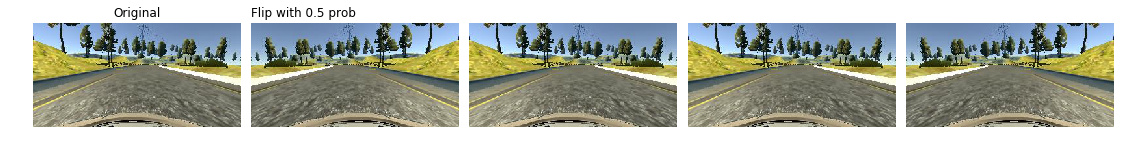

In [10]:
fig = print_sample_transformation(random_flip, 'Flip with 0.5 prob', sample_image, sample_angle)
fig.savefig('report-images/random_flip')

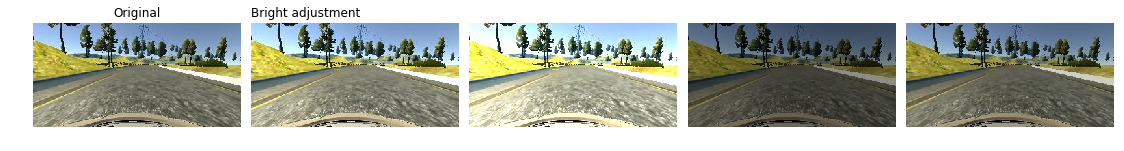

In [11]:
fig = print_sample_transformation(random_brightness_correction, 'Bright adjustment', sample_image, sample_angle)
fig.savefig('report-images/random_brightness_correction')

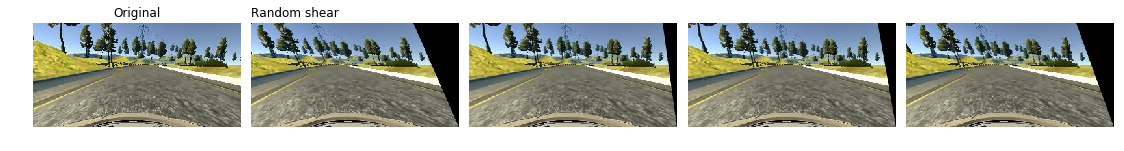

In [12]:
fig = print_sample_transformation(random_shear, 'Random shear', sample_image, sample_angle)
fig.savefig('report-images/random_shear')

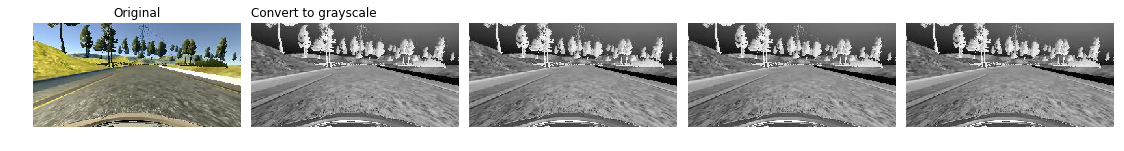

In [13]:
fig = print_sample_transformation(conv_to_graysale, 'Convert to grayscale', sample_image, None)
fig.savefig('report-images/conv_to_graysale')

In [14]:
def resize_pipeline(image):
    
    fig = plt.figure(figsize = (15, 5))
    #fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    counter = 0
    
    # Print non-transformed image
    counter += 1
    imgplt = fig.add_subplot(1, 3, counter, autoscale_on = True)
    imgplt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('Original', fontsize = 12)

    
    # Print cropped image
    counter += 1
    cropped_image = crop(image)
    imgplt = fig.add_subplot(1, 3, counter, autoscale_on = True)
    imgplt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('Cropped', fontsize = 16)

    
    #Print resized image
    counter += 1
    resized_image = resize(cropped_image)
    imgplt = fig.add_subplot(1, 3, counter, autoscale_on = True)
    imgplt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('Resized', fontsize = 12)
    
    return fig

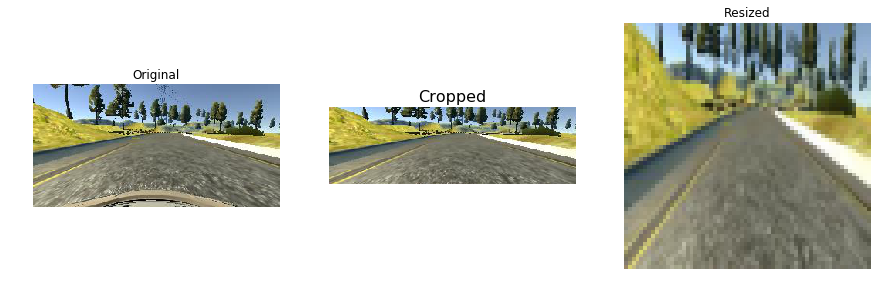

In [15]:
fig = resize_pipeline(sample_image)
fig.savefig('report-images/resize_pipeline')

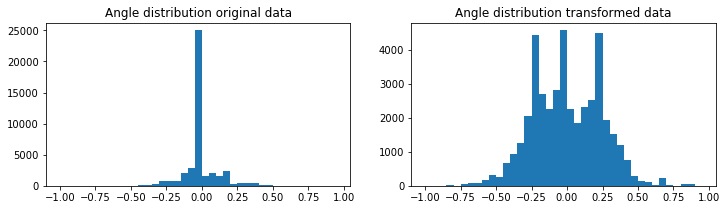

In [16]:
sample_size = 50

tr_angles = []
counter = 0
for images, angles in transformed_data_generator(csv_file, shear_prob = 0.65, image_load = False):
    counter += 1
    tr_angles = np.concatenate((tr_angles, angles))
    if counter > sample_size: break

or_angles = []
counter = 0
for images, angles in original_data_generator(csv_file, image_load = False):
    counter += 1
    or_angles = np.concatenate((or_angles, angles))
    if counter > sample_size: break        
        
buckets = np.arange(-1,1,0.05)

fig = plt.figure(figsize = (12, 3))
#fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

hstplt = fig.add_subplot(1, 2, 1)
hist = hstplt.hist(or_angles, bins = buckets)
hstplt.set_title('Angle distribution original data')

hstplt = fig.add_subplot(1, 2, 2)
hist = hstplt.hist(tr_angles, bins = buckets)
hstplt.set_title('Angle distribution transformed data')

fig.savefig('report-images/angle_distribution')

## Generators

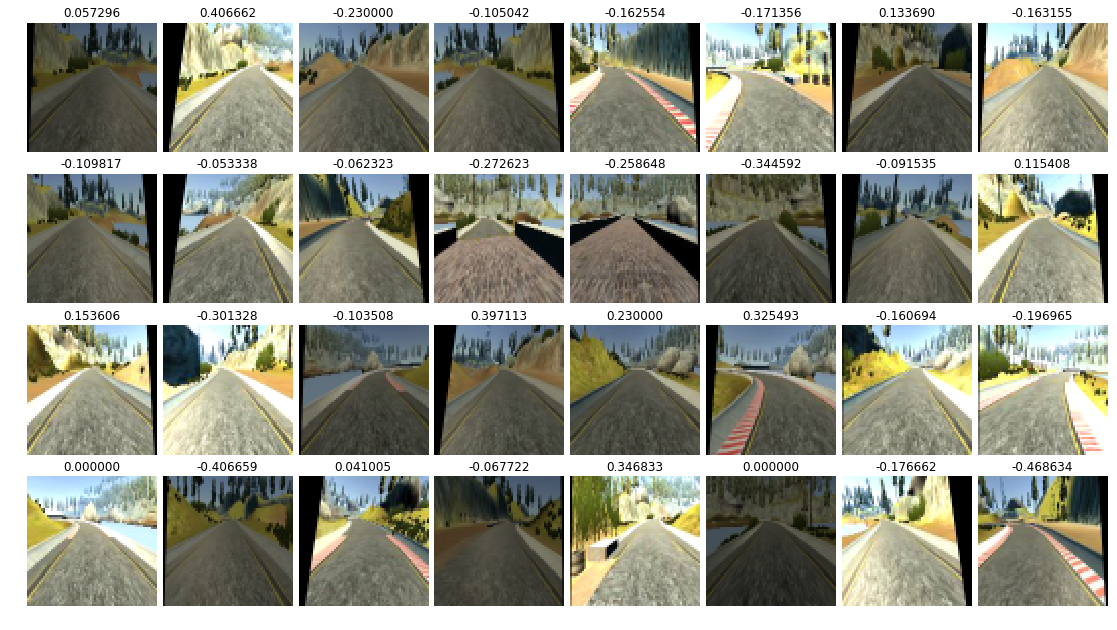

In [17]:
for images, angles in transformed_data_generator(csv_file):
    break

plot_width, plot_height = 15, 8.3
grid_rows, grid_cols = 4, 8

fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for image, angle in zip(images[:32], angles[:32]):
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    counter += 1
    imgplt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('{:f}'.format(angle))
fig.savefig('report-images/image_generator')

In [20]:
from utils import lenet_generator
for images, angles in lenet_generator(csv_file):
    break
    
plot_width, plot_height = 15, 8.3
grid_rows, grid_cols = 4, 8

fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for image, angle in zip(images[:32], angles[:32]):
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    counter += 1
    imgplt.imshow(image.squeeze(), cmap='gray_r')
    imgplt.axis('off')
    imgplt.set_title('{:f}'.format(angle))
fig.savefig('report-images/lenet_image_generator')

ImportError: cannot import name 'lenet_generator'

## Models

### Very simple model

In [35]:
simple_train_generator = original_data_generator(csv_train, tr_fn=[crop, resize])
simple_valid_generator = original_data_generator(csv_valid, tr_fn=[crop, resize])

In [36]:
#\---> MODEL DEFINITION <----------------------------------------------------\#
def create_model_simple():
    '''
    Very simple model
    '''
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(64,64,3)))
    model.add(Flatten())
    model.add(Dense(1))    
    model.compile(optimizer=Adam(), loss='mse')
    return model

### NVidia model

In [ ]:
### Model definition
learning_rate = 0.0001
keep_prob = 0.5
def create_nv_model():
    
    # Define nvidia model
    model = Sequential()

    # Lambda layer
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (64, 64, 3)))
    
    # Convolutional layers
    model.add(Conv2D(24, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(36, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(48, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(64, (3, 3), padding = 'same', strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(64, (3, 3), padding = 'valid', strides = (2, 2), activation = 'relu'))
    
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(1164, activation = 'relu'))
    model.add(Dropout(keep_prob))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(keep_prob))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dropout(keep_prob))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1))
    
    model.compile(loss = 'mse', optimizer = Adam())
    return model

### LeNet model

In [26]:
#\---> MODEL DEFINITION <----------------------------------------------------\#
def create_model_c4f3():
    
    model = Sequential()
    
    model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(64,64,3)))
    
    model.add(Convolution2D(32, 8,8 ,border_mode='same', subsample=(4,4)))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 8,8 ,border_mode='same',subsample=(4,4)))
    model.add(Activation('relu',name='relu2'))
    model.add(Convolution2D(128, 4,4,border_mode='same',subsample=(2,2)))
    model.add(Activation('relu'))
    model.add(Convolution2D(128, 2,2,border_mode='same',subsample=(1,1)))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(), loss='mse')
    
    return model

### Simplified nvidia model

In [27]:
def create_simple_nv_model():
    # Define nvidia model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (64, 64, 3)))
    model.add(Conv2D(24, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(36, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(48, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(64, (3, 3), padding = 'same', strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(64, (3, 3), padding = 'valid', strides = (2, 2), activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Dense(16))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = 'adam')
    return model

### Train model

In [37]:
### Choose model
model_fn = create_model_simple
train_generator = simple_train_generator
valid_generator = simple_valid_generator
epochs = 8

In [43]:
model_name = 'simple_model'

In [38]:
### Model creation / summary and graph
model = model_fn()
model.summary()
plot_model(model, show_shapes = True, show_layer_names = True, to_file='report-images/'+model_name+'.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 12289     
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


In [39]:
### Model training
model_hst_object = \
    model.fit_generator(train_generator,
                        steps_per_epoch = len(csv_train)/BATCH_SIZE,
                        epochs = epochs,
                        validation_data = valid_generator,
                        validation_steps = len(csv_valid)/BATCH_SIZE)

Epoch 1/8
201/200 [==============================] - 144s - loss: 0.0467 - val_loss: 0.0211
Epoch 2/8
201/200 [==============================] - 126s - loss: 0.0092 - val_loss: 0.0164
Epoch 3/8
201/200 [==============================] - 147s - loss: 0.0061 - val_loss: 0.0142
Epoch 4/8
201/200 [==============================] - 135s - loss: 0.0046 - val_loss: 0.0138
Epoch 5/8
201/200 [==============================] - 135s - loss: 0.0042 - val_loss: 0.0144
Epoch 6/8
201/200 [==============================] - 142s - loss: 0.0052 - val_loss: 0.0132
Epoch 7/8
201/200 [==============================] - 155s - loss: 0.0046 - val_loss: 0.0137
Epoch 8/8
201/200 [==============================] - 146s - loss: 0.0110 - val_loss: 0.0131


In [45]:
### Save model
model_file = 'models/'+model_name+'.h5'
delete_file(model_file)
model.save(model_file)

In [46]:
### Calculate accuracy
max_counter = 100
counter = 0
accuracies = []
for images, angles in valid_generator:
    steering_angles = model.predict(images).T
    real_signs = np.sign(angles)
    pred_signs = np.sign(steering_angles)
    accuracy = np.sum(real_signs == pred_signs)/len(angles)
    accuracies.append(accuracy)
    counter += 1
    if counter > max_counter: break
print('Acuracy = {:%}'.format(np.mean(accuracies)))

Acuracy = 37.705020%


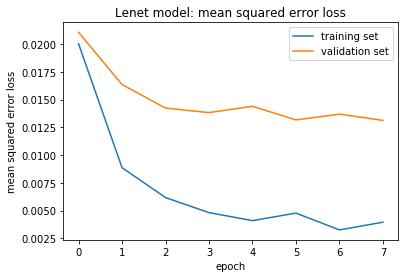

In [47]:
### Show learning curves
### plot the training and validation loss for each epoch
plt.plot(model_hst_object.history['loss'])
plt.plot(model_hst_object.history['val_loss'])
plt.title('Lenet model: mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('report-images/nv_train_valid_loss')